# Crossmatching ZTF alerts and CDS catalogs

The cross-matching modules in Fink take all the alerts that pass the quality cut criteria and add information on close-by sources from astronomical catalogues and other real-time surveys.

This notebook explores the output of the [xmatch](http://cdsxmatch.u-strasbg.fr/) service provided by the Centre de Données astronomiques de Strasbourg (CDS) on [ZTF](https://www.ztf.caltech.edu) alert data. This service is tailored for cross-matching large catalogues, and provides an intuitive API. Alerts are sent upon receival by large batches to the xmatch service to reduce the number of necessary calls. The service performs a positional cross-match within a radius of 1 arcsecond with the objects from the Simbad catalogue (Wenger et al. 2000), and returns all results within a few seconds. In the case of multiple matches within this radius, we currently select only the closest object. This information is then added to the original alert packet. The choice of catalogues to cross-match against, and the cross-match radius can be changed in the future but it is standardised for all alerts.

<img src="img/Fink_PrimaryLogo_WEB.png" alt="drawing" width="500"/>

In [1]:
from visualisation import spider_plot
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('talk')

## Loading Fink data with Apache Spark

In order to accommodate the paradigm change introduced by the multi-TB alert data set of LSST, Fink is designed to take advantage of new technological approaches based on big data tools. We primarily use [Apache Spark](https://spark.apache.org/) to efficiently manipulate the data. Let's load processed data from November 2019 by Fink, stored on the VirtualData cloud:

In [2]:
# processed data for November 2019
df = spark.read.format('parquet').load('ztf_alerts/science_reprocessed/year=2019/month=11')
tot = df.count()

In [3]:
# Number of alerts that survived quality cuts
print('{} alerts pass the quality cuts'.format(tot))

1515953 alerts pass the quality cuts


The data is loaded in a DataFrame (think of a distributed table). We can inspect a few fields for a few alerts:

In [4]:
cols = ['objectId', 'candidate.candid', 'candidate.magpsf', 'cdsxmatch', 'snn_snia_vs_nonia', 'fink_science_version', 'fink_broker_version']
df.select(cols).show(10)

+------------+-------------------+---------+---------+-------------------+--------------------+-------------------+
|    objectId|             candid|   magpsf|cdsxmatch|  snn_snia_vs_nonia|fink_science_version|fink_broker_version|
+------------+-------------------+---------+---------+-------------------+--------------------+-------------------+
|ZTF18abpubcn|1036263872915015010| 19.87067|  Unknown| 0.0803888663649559|               0.3.6|              0.7.0|
|ZTF17aabvegs|1036260995215015006|19.199179|  Unknown| 0.4061468839645386|               0.3.6|              0.7.0|
|ZTF18aaxyrnp|1036262371515010027| 18.79559|       V*|0.05720263347029686|               0.3.6|              0.7.0|
|ZTF18abboayd|1036260994015010045|17.951935|  Unknown| 0.9056084752082825|               0.3.6|              0.7.0|
|ZTF19abykued|1036263872915015004| 18.63067|  Unknown| 0.7053014636039734|               0.3.6|              0.7.0|
|ZTF18abdazjk|1036260990515010054|17.373325|  Unknown| 0.585472941398620

In addition to the information contained in the incoming raw alerts (see [ZTF alerts schema](https://zwickytransientfacility.github.io/ztf-avro-alert/) for example), Fink attached new information coming from the science module. This information is in form of extra fields inside the alert packet, and you would access to it the same way as any other fields. Below we summarise the fields added by the [Fink science modules](https://github.com/astrolabsoftware/fink-science):

| Field | Type | Contents |
|:--------|:-------|:--------|
| `cdsxmatch` | string | Counterpart (cross-match) in the Simbad database using CDS xmatch service |
| `rfscore` | float | Probability to be a SN Ia based on Random Forest classifier (1 is SN Ia). Based on https://arxiv.org/abs/1804.03765 |
| `snn_snia_vs_nonia` | float | Probability to be a SNe Ia based on Neural Network (1 is SN Ia). Based on https://arxiv.org/abs/1901.06384 |
| `snn_sn_vs_all` | float | Probability to be a SNe based on Neural Network (1 is SN Ia). Based on https://arxiv.org/abs/1901.06384 |
| `mulens.class_1` | string | predicted class by [LIA](https://github.com/dgodinez77/LIA) for filter band g |
| `mulens.ml_score_1` | float | probability of an alert by [LIA](https://github.com/dgodinez77/LIA) (0 to 1) to be a microlensing event in filter band g using a Random Forest Classifier |
| `mulens.class_2` | string | predicted class by [LIA](https://github.com/dgodinez77/LIA) for filter band r |
| `mulens.ml_score_2` | float | probability of an alert by [LIA](https://github.com/dgodinez77/LIA) (0 to 1) to be a microlensing event in filter band r using a Random Forest Classifier |
|`roid`| int | Asteroid classification |

Over time, there will be more added values available - and feel free to propose new modules! In this notebook, we focus on the `snn_snia_vs_nonia` bring by the SuperNNova module.

## Most frequent categories

Around ~20% of alerts have typically a counterpart in Simbad:

In [5]:
nalertslabeled = df.filter(df['cdsxmatch'] != 'Unknown').count()
print('{} alerts have a counterpart in Simbad ({}%)'.format(
    nalertslabeled, nalertslabeled/tot*100
))

303534 alerts have a counterpart in Simbad (20.02265241732428%)


Let's inspect the 10 most frequent matches between the ZTF alert stream and the Simbad catalog. First, let's group the data by `cdsxmatch` values:

In [6]:
df_grouped = df.select('cdsxmatch').groupBy('cdsxmatch').count()
pdf = df_grouped.toPandas()

and then plot the 10 most frequent categories

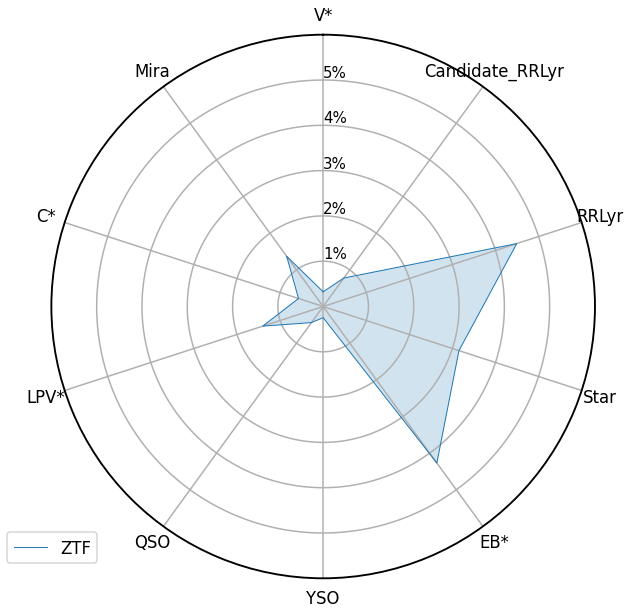

In [7]:
n_categories = 10

# Initialise the spider plot
fig = plt.figure(figsize=(10, 10))
ax = plt.subplot(111, polar=True)

mask = pdf['cdsxmatch'] != 'Unknown'
cols = pdf[mask].sort_values('count', ascending=False)[0:n_categories].cdsxmatch.values

# shuffle the data for clarity but fix the seed for reproducibility
np.random.seed(7)
np.random.shuffle(cols)

pdf.index = pdf.cdsxmatch.values

spider_plot(
    pdf.loc[cols].cdsxmatch.values, 
    pdf.loc[cols]['count'].values, 
    tot, ticks=[1, 2, 3, 4, 5], legend='ZTF', ax=ax)

plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))
plt.show()

No suprises - variable stars are leading! Variable Star of RR Lyr type (RRLyr), Eclipsing binary (EB*), and variable stars without subtype (Star) are counting for more than 10% of the total matches.

## Going further

All categories can be found at http://simbad.u-strasbg.fr/simbad/sim-display?data=otypes. You can also run `SELECT * FROM otypedef` at http://simbad.u-strasbg.fr/simbad/sim-tap) to get the latest labels. Here are all the labels for November 2019:

In [8]:
pd.set_option('display.max_rows', None)
pdf.sort_values('count', ascending=False)

,cdsxmatch,count
Unknown,Unknown,1212419
RRLyr,RRLyr,68113
EB*,EB*,64723
Star,Star,47782
LPV*,LPV*,21284
Mira,Mira,20793
Candidate_RRLyr,Candidate_RRLyr,11784
C*,C*,8668
QSO,QSO,6650
V*,V*,4917
